In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
from matplotlib import pyplot as plt
%matplotlib inline

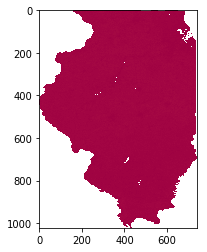

In [4]:
#Load the GCVI file 
gcvi = rasterio.open('GCVI_filled_2016191.tif')
state = gpd.read_file('cb_2017_us_state_500k/')
state.crs = gcvi.crs
state.iloc[1].geometry

img_clip, trans = rasterio.mask.mask(gcvi, [state.iloc[1].geometry], crop=True)
img_clip = img_clip.astype('float32')
img_clip[img_clip == 0] = np.nan
plt.imshow(img_clip[0,:,:],vmin=0, vmax=800, cmap='Spectral')


In [5]:
#Change the CDL data to corn/non-corn
cdl = rasterio.open('CDL_2016.tif')
cdl_data = cdl.read(1)
cdl_data[cdl_data != 1] = 0

In [6]:
#Project the CDL to GCVI size
from rasterio import Affine
from rasterio.warp import reproject, Resampling

newarr = np.empty(shape=(img_clip.shape[0], 
                         img_clip.shape[1],img_clip.shape[2]))

reproject(
    cdl_data, newarr,
    src_transform = cdl.transform,
    dst_transform = gcvi.transform,
    src_crs = cdl.crs,
    dst_crs = gcvi.crs,
    resampling = Resampling.average)

In [11]:
#Bigger than 0.5 means there is corn, while smaller than 0.5 means no corn
is_corn = newarr >= 0.5
corn_field = is_corn.astype(int)
corn_field = corn_field.astype(np.float64)


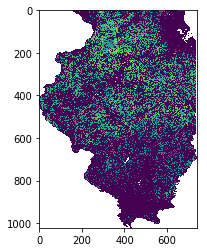

In [12]:
#Finally mask the corn/non-corn matrix with gcvi to get gcvi indexes
gcvi_corn = np.multiply(img_clip, corn_field)
plt.imshow(gcvi_corn.squeeze())

In [13]:
#checking whether there is a null value 
#np.isnan(corn_field).sum()

#Re-Write the projected GCVI to a new tif file
new_dataset = rasterio.open('filter1.tif', 'w', driver='GTiff',
                            height = corn_field.shape[1], width = corn_field.shape[2],
                            count = 1, dtype = corn_field.dtype,
                            crs = gcvi.crs,
                            transform = gcvi.transform)

new_dataset.write(gcvi_corn.squeeze(),1)
new_dataset.close()


In [14]:
#Process the county sowing dataset
df = pd.read_csv('maize.alldat.nolatlon.csv')
IL = df['state']=='IL'
IL_county = df[IL]
col_list = ['FIPS','sday']
IL_county = IL_county[col_list]
IL_county = IL_county.groupby(['FIPS']).mean()
sow_date = list(IL_county['sday'])
del df

#Get all county FIPS in Illinois
county_FIPS = IL_county.index.values
county_FIPS = county_FIPS.tolist()
county_FIPS = list(map(str,county_FIPS))

In [15]:
#Get all counties in IL in the shape file
ds = gpd.read_file('CoUS_GCS12.shp')
ds = ds[ds['atlas_stco'].isin(county_FIPS)]
cols = ['atlas_stco','geometry']
ds = ds[cols]
ds.crs = cdl.crs
num_of_county = len(ds.index)


In [16]:
def mask_by_county(ds, corn, i):
    img_clip, trans = rasterio.mask.mask(corn, [ds.iloc[i].geometry], crop=True) 
    img_clip = img_clip.astype('float32')
    img_clip[img_clip == 0] = np.nan
    index = np.nanmean(img_clip)
    return (img_clip[0,:,:],index)

#Read saved gcvi_corn raster file for masking
test = rasterio.open('filter1.tif')
corn_by_county = {}
index_by_county = {}

for county in range(num_of_county):
    result = mask_by_county(ds,test,county)
    corn_by_county[county] = result[0]
    index_by_county[county] = result[1]    

Average vegetation index is 5.9572887


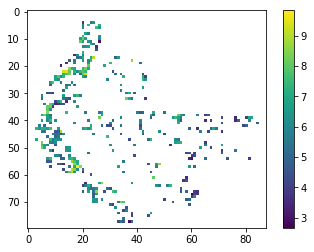

In [20]:
i = 60
plt.imshow(corn_by_county[i])
plt.colorbar()
print("Average vegetation index is "+ str(index_by_county[i]))